# Overview FEMA Spending

## Input Files:
- HELP HELP.xlsx

## Output Files:
- fema_fed_by_month.xlsx
- fema_state_by_month.xlsx
- fema_total_by_month.xlsx

## Error Files:
- fema_err_start_date.csv
- fema_err_end_date.csv
- fema_err_start_date_gt_end_date.csv
- fema_err_total_spend.csv
- fema_err_fed_spend.csv
- fema_err_state_spend.csv


## Preliminaries

In [1]:
# set to true to create output files again
create_output_files = False
#chunk_size = 200000
chunk_size = 100000
#chunk_size=2

In [2]:
import pandas as pd
import numpy as np
import re
import glob
import os
import pickle
import datetime
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from scipy.stats import rvs_ratio_uniforms
from sympy import *
import sympy
import scipy.stats as stats

### Files and Directories

In [3]:
# Base
#base_dir = "./Rich"
base_dir = '/content/drive/MyDrive/environment'
out_dir = os.path.join(base_dir,"out2")

# FEMA
fema_in_file = "HELP HELP.xlsx"
#fema_in_file = "HELP HELP2.xlsx"
fema_fed_out_file = "fema_fed_by_month"     # .csv or xlsx added later
fema_st_out_file = "fema_state_by_month"    # .csv or xlsx added later
fema_tot_out_file = "fema_total_by_month"   # .csv or xlsx added later

fema_err_dt1_out_file = "fema_err_start_date.csv"
fema_err_dt2_out_file = "fema_err_end_date.csv"
fema_err_dt2_lt_dt1_file = "fema_err_start_date_gt_end_date.csv"
fema_err_tot_spend = "fema_err_total_spend.csv"
fema_err_fed_spend = "fema_err_fed_spend.csv"
fema_err_st_spend = "fema_err_state_spend.csv"

### Distributions for Model Spending

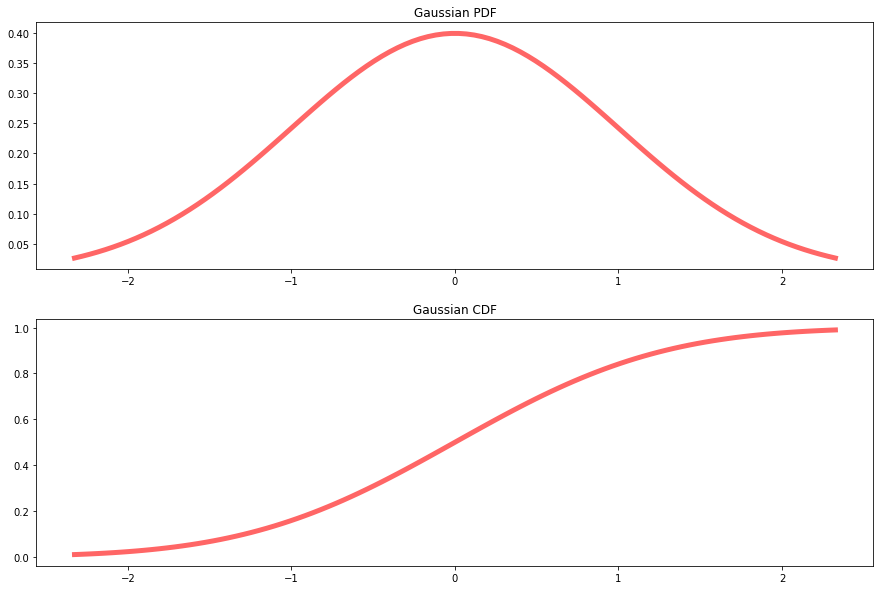

In [4]:
fig, ax = plt.subplots(2, 1)
fig.set_figheight(10)
fig.set_figwidth(15)
x = np.linspace(stats.norm.ppf(0.01),stats.norm.ppf(0.99), 100)
ax[0].plot(x, stats.norm.pdf(x),'r-', lw=5, alpha=0.6, label='norm pdf')
ax[0].set_title("Gaussian PDF")
ax[1].plot(x, stats.norm.cdf(x),'r-', lw=5, alpha=0.6, label='norm cdf')
ax[1].set_title("Gaussian CDF")
plt.show()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


0.08392401699487584
3.986075498056125e-06
11915.540220876905
1000.0


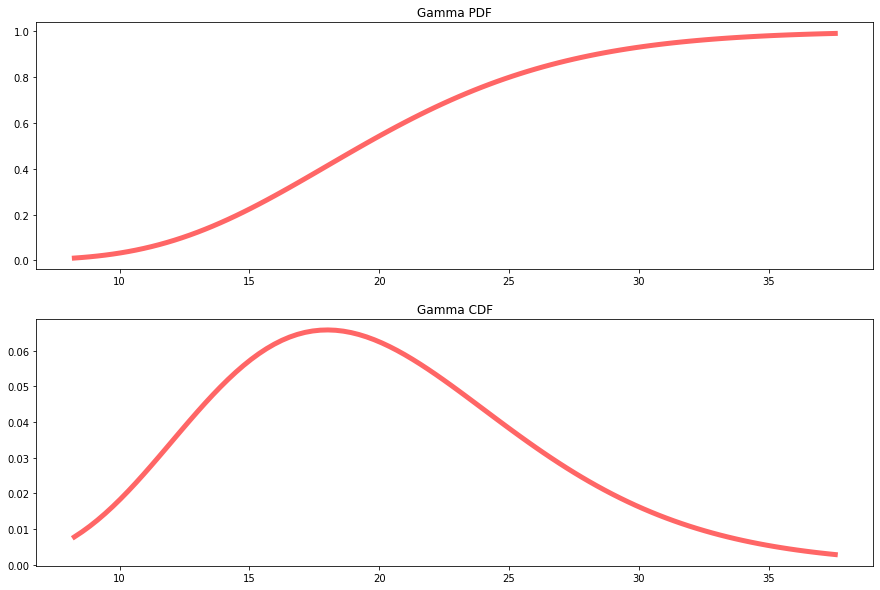

In [6]:
fig, ax = plt.subplots(2, 1)
fig.set_figheight(10)
fig.set_figwidth(15)
#a = 1.99
#gamma_max = 15
a = 10
gamma_max = 40
beta_inv = 2
gamma_cover = stats.gamma.cdf(gamma_max,a,scale=beta_inv)
x = np.linspace(stats.gamma.ppf(0.01, a, scale=beta_inv),
                stats.gamma.ppf(0.99, a, scale=beta_inv), 100)
ax[0].plot(x, stats.gamma.cdf(x, a, scale=beta_inv),'r-', lw=5, alpha=0.6, 
        label='gamma pdf')
ax[0].set_title("Gamma PDF")
ax[1].plot(x, stats.gamma.pdf(x, a, scale=beta_inv),'r-', lw=5, alpha=0.6, 
        label='gamma pdf')
ax[1].set_title("Gamma CDF")

print(stats.gamma.cdf(12,a,scale=beta_inv))
print(stats.gamma.cdf(3,a,scale=beta_inv)-stats.gamma.cdf(2,a,scale=beta_inv))
print(1000/stats.gamma.cdf(12,a,scale=beta_inv))
val = 1000/gamma_cover
print((stats.gamma.cdf(gamma_max/4,a,scale=beta_inv) + \
       (stats.gamma.cdf(gamma_max/2,a,scale=beta_inv) - \
        stats.gamma.cdf(gamma_max/4,a,scale=beta_inv)) + \
       (stats.gamma.cdf(3*gamma_max/4,a,scale=beta_inv) - \
        stats.gamma.cdf(gamma_max/2,a,scale=beta_inv)) + \
       (stats.gamma.cdf(gamma_max,a,scale=beta_inv) - \
        stats.gamma.cdf(3*gamma_max/4,a,scale=beta_inv)))*val) 
plt.show()

## Process FEMA

In [7]:
def clean_up_file(filename):
    filepath = os.path.join(base_dir,filename)
    if os.path.exists(filepath):
        print(F"removing {filepath}...")
        os.remove(filepath)

In [8]:
def clean_up_excel_files(filename):
    file_list = glob.glob(os.path.join(base_dir,F"{filename}_*.xlsx"))
    for filepath in file_list:
        print(F"removing {filepath}...")
        os.remove(filepath)

In [9]:
clean_up_file(F"{fema_fed_out_file}.xlsx")
clean_up_file(F"{fema_st_out_file}.xlsx")
clean_up_file(F"{fema_tot_out_file}.xlsx")
clean_up_file(fema_err_dt1_out_file)
clean_up_file(fema_err_dt2_out_file)
clean_up_file(fema_err_dt2_lt_dt1_file)
clean_up_file(fema_err_tot_spend)
clean_up_file(fema_err_fed_spend)
clean_up_file(fema_err_st_spend)

removing /content/drive/MyDrive/environment/fema_fed_by_month.xlsx...
removing /content/drive/MyDrive/environment/fema_state_by_month.xlsx...
removing /content/drive/MyDrive/environment/fema_total_by_month.xlsx...


In [10]:
dffema = None   # master set
dti = None
df = None       # chunk set
use_gaussian = True
cdfbins = 1000
cdftot = 1000000
cdf = None

In [11]:
def clean():
    global dffema

    # set non-numeric years or months to 0
    dffema["START YR"] = \
        pd.to_numeric(dffema["START YR"], \
                      errors='coerce').fillna(0).astype('int')
    dffema["START MO"] = \
        pd.to_numeric(dffema["START MO"], \
                      errors='coerce').fillna(0).astype('int')
    dffema["END YR"] = \
        pd.to_numeric(dffema["END YR"], \
                      errors='coerce').fillna(0).astype('int')
    dffema["END MO"] = \
        pd.to_numeric(dffema["END MO"], \
                      errors='coerce').fillna(0).astype('int')
    
    # set end date to match start date in the case where end month was zero 
    # or was originally non-numeric (which was set to 0 above)
    baddates = (dffema["END MO"]==0)
    dffema.loc[baddates,"END YR"] = dffema[baddates]["START YR"]
    dffema.loc[baddates,"END MO"] = dffema[baddates]["START MO"]

    # record rows with bad start dates to an error file
    dferr = dffema[pd.to_datetime(dffema["START MO"].astype(str) + " " \
                                    + dffema["START YR"].astype(str), 
                                    errors="coerce").isna()]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt1_out_file))

    # record rows with bad end dates to an error file
    dferr = dffema[pd.to_datetime(dffema["END MO"].astype(str) + " " \
                                    + dffema["END YR"].astype(str),
                                    errors="coerce").isna()]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt2_out_file))

    # remove rows with bad start dates and bad end dates from dataframe
    dffema = dffema[pd.to_datetime(dffema["START MO"].astype(str) + \
                                    " " + dffema["START YR"].astype(str), 
                                    errors="coerce").notna()]
    dffema = dffema[pd.to_datetime(dffema["END MO"].astype(str) + \
                                    " " + dffema["END YR"].astype(str),
                                    errors="coerce").notna()]

    # record rows with end date < start dates to error file
    dferr = dffema[(pd.to_datetime(dffema['END YR'].astype(str) \
                                   + " "+dffema['END MO'].astype(str))) \
                   < (pd.to_datetime(dffema['START YR'].astype(str) \
                                     + " " + dffema['START MO'].astype(str)))]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt2_lt_dt1_file))

    # remove rows with end date < start date from dataframe
    dffema = dffema[(pd.to_datetime(dffema['END YR'].astype(str) \
                                   + " "+dffema['END MO'].astype(str))) \
                   >= (pd.to_datetime(dffema['START YR'].astype(str) \
                                     + " " + dffema['START MO'].astype(str)))]
    
    # set non-numeric SPEND values to 0 
    dffema["TOTAL PROJECT SPEND"] = \
        pd.to_numeric(dffema["TOTAL PROJECT SPEND"], \
                      errors='coerce').fillna(0).astype('float').round(2)
    dffema["FED SPEND"] = \
        pd.to_numeric(dffema["FED SPEND"], \
                      errors='coerce').fillna(0).astype('float').round(2)
    dffema["STATE SPEND"] = \
        pd.to_numeric(dffema["STATE SPEND"], \
                      errors='coerce').fillna(0).astype('float').round(2)

In [12]:
def create_dates_index():
    global dffema
    global dti
    dti = pd.date_range(start=pd.to_datetime(dffema["START MO"].astype(str) + \
                                            " " + dffema["START YR"].astype(str)).min(),
                        end=pd.to_datetime(dffema["END MO"].astype(str) + \
                                            " " + dffema["END YR"].astype(str),
                                            format="%m %Y").max()+MonthEnd(0),
                        freq='M').strftime("%Y-%m")

In [13]:
# def build_gassian_prototype():
#     global cdf
#     seed = 47563
#     rng = np.random.default_rng(seed)

#     mu = cdfbins/2
#     sigma = cdfbins/6
    
#     a, b = (0 - mu) / sigma, ((cdfbins-1) - mu) / sigma
    
#     cdf = stats.truncnorm.rvs(a,b,loc=mu,scale=sigma,
#                               size=cdftot,random_state=rng).round().astype(int)
#     _ = plt.hist(cdf,bins=np.arange(cdfbins))
#     cdf = np.bincount(cdf)
#     for i in np.arange(cdfbins):
#          if i == 0:
#              continue
#          cdf[i] += cdf[i-1]

In [14]:
# build_gassian_prototype()

In [15]:
dffema = pd.DataFrame(pd.read_excel(os.path.join(base_dir,fema_in_file),
                                    header=1,
                                    sheet_name='HELP',
                                    usecols=np.arange(12).tolist()))

In [16]:
headers = dffema.columns
dummy_index = dffema.index[-1]+1
clean()
create_dates_index()
display(dffema)
dffema_len = len(dffema)
df_orig = None
df = None

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,1039431.28,0.00
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,1998.38,666.13
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,17185.70,5728.57
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,70000.00,0.00
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.00,187500.00,0.00
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.00,250000.00,0.00
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.00,500000.00,0.00
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.00,562500.00,0.00
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.00,1000000.00,0.00


In [17]:
def create_spend_report(display_result=True,save=False,
                        test_sums=False,n=0):
    global df
    # update single month
    df.loc[df["months"]==1,"spendtot"] = df[df["months"]==1]["TOTAL PROJECT SPEND"]
    df.loc[df["months"]==1,"spendfed"] = df[df["months"]==1]["FED SPEND"]
    df.loc[df["months"]==1,"spendst"] = df[df["months"]==1]["STATE SPEND"]

    # map proportion needed to the proportion of the cdf
    #stats.gamma.cdf(gamma_max/4,a,scale=beta_inv
    cdffunc = lambda x, s: (round((stats.gamma.cdf(((x["mindex"]+1)/x['months']).astype("float")*gamma_max,
                                                   a, scale=beta_inv) - \
                               stats.gamma.cdf((x["mindex"]/x["months"]).astype("float")*gamma_max,
                                               a, scale=beta_inv))*(x[s]/gamma_cover),2))
    #cdffunc = lambda x: cdffunc1(x,colspend)
    cdffunctot = lambda x: cdffunc(x,"TOTAL PROJECT SPEND")
    cdffuncfed = lambda x: cdffunc(x,"FED SPEND")
    cdffuncst = lambda x: cdffunc(x,"STATE SPEND")

    print("distributing spend value over time period...")
    criteria = (df["months"]>1)
    df.loc[criteria,"spendtot"] = df[criteria].apply(cdffunctot,axis=1)
    df.loc[criteria,"spendfed"] = df[criteria].apply(cdffuncfed,axis=1)
    df.loc[criteria,"spendst"] = df[criteria].apply(cdffuncst,axis=1)

    print("correcting rounding errors...")
    # adjust "middle" element to compensate for rounding error
    def adjust(colspend,spend):
        tmp = pd.DataFrame(df[df["months"]>1].groupby(axis=0,level=0)[spend].sum())
        df.loc[(df["months"]>1) \
               & (df["mindex"] == (df["months"]/2).astype(int)),spend] += \
                (df[(df["months"]>1) \
                    & (df["mindex"] \
                       == (df["months"]/2).astype(int))][colspend] - tmp[spend]).round(2)
    adjust("TOTAL PROJECT SPEND","spendtot")
    adjust("FED SPEND","spendfed")
    adjust("STATE SPEND","spendst")

    def test(colspend,spend):
        if test_sums:
            tmp = pd.DataFrame(df[df["months"]>1].groupby(axis=0,level=0)["spend"].sum())
            tmp2 = df[(df["months"]>1) & (df["mindex"]==1)]
            tmp3 = tmp2[((tmp2[colspend]-tmp[spend]).abs().round(2))>0.0]
            if len(tmp3) != 0:
                print("The following rows failed the test...")
                display(tmp3)
            else:
                print("Passed!")
    test("TOTAL PROJECT SPEND","spendtot")
    test("FED SPEND","spendfed")
    test("STATE SPEND","spendst")

    print("dropping obsolete columns...")
    # dispose of columns no longer needed
    df = df.drop(["TOTAL PROJECT SPEND","FED SPEND",
                          "STATE SPEND","months","mindex"],axis=1)

    print("appending dummy row to cover date range...")
    # add dummy data, so that even date columns without data will be created
    # this row will not be included in final result since index will not match
    # any index in df_orig, but it will keep the columns, which is the point
    #df = df.append(pd.DataFrame({"range":dti,"spend":0.0},
    df = df.append(pd.DataFrame({"range":dti,
                                 "spendtot":0.0,"spendfed":0.0,"spendst":0.0},
                                        index=np.ones(shape=len(dti),dtype=int)*dummy_index,
                                        columns=["range",
                                                 "spendtot",
                                                 "spendfed",
                                                 "spendst"]))
    
    def pivot_and_save(spend,filename):
        #global df
        print(F"pivoting {spend} column...")
        # pivot spend to date columns
        df2 = df.pivot(values=spend,columns="range")
        df2.columns.name = ""
    
        print(F"joining {spend} data with original data...")
        # rejoin with original data
        df2 = df_orig.join(df2)
        
        if display_result and not test_sums:
            display(df)

        if save and not test_sums:
            filepath = os.path.join(base_dir,F"{filename}_{n}.xlsx")
            print(F"writing to {filepath}...")
            df2.to_excel(filepath, header=True)
            print(F"{filepath} created!")
    
    pivot_and_save("spendtot",fema_tot_out_file)
    pivot_and_save("spendfed",fema_fed_out_file)
    pivot_and_save("spendst",fema_st_out_file)

In [18]:
def prep(copy_orig=True):
    global df
    if copy_orig:
        df = df_orig.copy()

    # add range column (list of n months from start to end, formate YYYY-MM)
    dt1 = pd.to_datetime(df["START MO"].astype(str) + " " \
                         + df["START YR"].astype(str))
    dt2 = pd.to_datetime(df["END MO"].astype(str) + " " \
                         + df["END YR"].astype(str)) + MonthEnd(0)
    df["range"] = [pd.date_range(a, b, freq='M').strftime("%Y-%m").tolist() \
                   for a, b in zip(dt1, dt2)]

    # add months column (n, single number per row, not a list)
    df["months"] = df["range"].apply(len)

    # add mindex column (0 to n-1)
    df["mindex"] = df["months"].apply(np.arange)

    # add spend column (list of n 0.0's, placeholder for the calculated spend later
    df["spend"] = df["months"].apply(np.zeros)

    # drop all but the above 4 columns + index
    df = df.drop(["FUND SOURCE","TYPE","COUNTY","STATE","START YR",\
                  "START MO","END YR","END MO","NUMBER OF MONTHS"],axis=1)

    # explode date, index and spend (each is a list with n elements)
    df = df.explode(["range","mindex","spend"])
    df["spend"] = df["spend"].astype(float)

    # add fraction column
    #df["fraction"] = ((1/df["months"]).astype(float) * cdfbins).astype(int)

In [19]:
#display(dffema)

In [20]:
# n = 1
# df = dffema[(dffema.index >= n*chunk_size) \
#             & (dffema.index < (n+1)*chunk_size)].copy()

# prep()
# colspend = "TOTAL PROJECT SPEND"
# df.loc[df["months"]==1,"spend"] = df[df["months"]==1][colspend]

# # map proportion needed to the proportion of the cdf
# #stats.gamma.cdf(gamma_max/4,a,scale=beta_inv
# cdffunc = lambda x: (round((stats.gamma.cdf(((x["mindex"]+1)/x['months']).astype("float")*gamma_max,
#                                             a, scale=beta_inv) - \
#                             stats.gamma.cdf((x["mindex"]/x["months"]).astype("float")*gamma_max,
#                                             a, scale=beta_inv))*x[colspend],2))
    
# # update first month in multi-month
# criteria = (df["months"]>1)
# df.loc[criteria,"spend"] = df[criteria].apply(cdffunc,axis=1)

In [21]:
test = False
if dffema_len > 0:
    n=0
    while True:
        df = dffema[(dffema.index >= n*chunk_size) \
                    & (dffema.index < (n+1)*chunk_size)].copy()
        # save space by making the master frame smaller as you go
        dffema = dffema[dffema.index >= (n+1)*chunk_size] 
        if len(df) > 0:
            df_orig = df.copy()
            prep(copy_orig=False)
            create_spend_report(test_sums=test,save=True,n=n)
            # prep(copy_orig=False)
            # create_spend_report("TOTAL PROJECT SPEND",test_sums=test,\
            #                     save=True,n=n)
            # prep()
            # create_spend_report("FED SPEND",display_result=False,\
            #                     test_sums=test,save=True,n=n)
            # prep()
            # create_spend_report("STATE SPEND",display_result=False,\
            #                     test_sums=test,save=True,n=n)
        print(F"iteration {n+1}: {len(df)} records read")
        n += 1
        if n*chunk_size > (dffema_len-1):
            break

distributing spend value over time period...
correcting rounding errors...
dropping obsolete columns...
appending dummy row to cover date range...
pivoting spendtot column...
joining spendtot data with original data...


,range,spend,spendtot,spendfed,spendst
0,2005-09,0.0,1039431.28,1039431.28,0.00
1,2012-08,0.0,2664.51,1998.38,666.13
27,1999-01,NaN,0.00,0.00,0.00
27,1999-02,NaN,0.00,0.00,0.00
27,1999-03,NaN,0.00,0.00,0.00
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_total_by_month_0.xlsx...
/content/drive/MyDrive/environment/fema_total_by_month_0.xlsx created!
pivoting spendfed column...
joining spendfed data with original data...


,range,spend,spendtot,spendfed,spendst
0,2005-09,0.0,1039431.28,1039431.28,0.00
1,2012-08,0.0,2664.51,1998.38,666.13
27,1999-01,NaN,0.00,0.00,0.00
27,1999-02,NaN,0.00,0.00,0.00
27,1999-03,NaN,0.00,0.00,0.00
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_fed_by_month_0.xlsx...
/content/drive/MyDrive/environment/fema_fed_by_month_0.xlsx created!
pivoting spendst column...
joining spendst data with original data...


,range,spend,spendtot,spendfed,spendst
0,2005-09,0.0,1039431.28,1039431.28,0.00
1,2012-08,0.0,2664.51,1998.38,666.13
27,1999-01,NaN,0.00,0.00,0.00
27,1999-02,NaN,0.00,0.00,0.00
27,1999-03,NaN,0.00,0.00,0.00
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_state_by_month_0.xlsx...
/content/drive/MyDrive/environment/fema_state_by_month_0.xlsx created!
iteration 1: 173 records read
distributing spend value over time period...
correcting rounding errors...
dropping obsolete columns...
appending dummy row to cover date range...
pivoting spendtot column...
joining spendtot data with original data...


,range,spend,spendtot,spendfed,spendst
2,2012-08,0.0,22914.27,17185.7,5728.57
3,1999-05,0.0,0.00,0.0,0.00
27,1999-01,NaN,0.00,0.0,0.00
27,1999-02,NaN,0.00,0.0,0.00
27,1999-03,NaN,0.00,0.0,0.00
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.0,0.00
27,2012-12,NaN,0.00,0.0,0.00
27,2013-01,NaN,0.00,0.0,0.00
27,2013-02,NaN,0.00,0.0,0.00


writing to /content/drive/MyDrive/environment/fema_total_by_month_1.xlsx...
/content/drive/MyDrive/environment/fema_total_by_month_1.xlsx created!
pivoting spendfed column...
joining spendfed data with original data...


,range,spend,spendtot,spendfed,spendst
2,2012-08,0.0,22914.27,17185.7,5728.57
3,1999-05,0.0,0.00,0.0,0.00
27,1999-01,NaN,0.00,0.0,0.00
27,1999-02,NaN,0.00,0.0,0.00
27,1999-03,NaN,0.00,0.0,0.00
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.0,0.00
27,2012-12,NaN,0.00,0.0,0.00
27,2013-01,NaN,0.00,0.0,0.00
27,2013-02,NaN,0.00,0.0,0.00


writing to /content/drive/MyDrive/environment/fema_fed_by_month_1.xlsx...
/content/drive/MyDrive/environment/fema_fed_by_month_1.xlsx created!
pivoting spendst column...
joining spendst data with original data...


,range,spend,spendtot,spendfed,spendst
2,2012-08,0.0,22914.27,17185.7,5728.57
3,1999-05,0.0,0.00,0.0,0.00
27,1999-01,NaN,0.00,0.0,0.00
27,1999-02,NaN,0.00,0.0,0.00
27,1999-03,NaN,0.00,0.0,0.00
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.0,0.00
27,2012-12,NaN,0.00,0.0,0.00
27,2013-01,NaN,0.00,0.0,0.00
27,2013-02,NaN,0.00,0.0,0.00


writing to /content/drive/MyDrive/environment/fema_state_by_month_1.xlsx...
/content/drive/MyDrive/environment/fema_state_by_month_1.xlsx created!
iteration 2: 173 records read
distributing spend value over time period...
correcting rounding errors...
dropping obsolete columns...
appending dummy row to cover date range...
pivoting spendtot column...
joining spendtot data with original data...


,range,spend,spendtot,spendfed,spendst
4,1999-05,0.0,70000.0,70000.0,0.0
5,1999-05,0.0,187500.0,187500.0,0.0
27,1999-01,NaN,0.0,0.0,0.0
27,1999-02,NaN,0.0,0.0,0.0
27,1999-03,NaN,0.0,0.0,0.0
...,...,...,...,...,...
27,2012-11,NaN,0.0,0.0,0.0
27,2012-12,NaN,0.0,0.0,0.0
27,2013-01,NaN,0.0,0.0,0.0
27,2013-02,NaN,0.0,0.0,0.0


writing to /content/drive/MyDrive/environment/fema_total_by_month_2.xlsx...
/content/drive/MyDrive/environment/fema_total_by_month_2.xlsx created!
pivoting spendfed column...
joining spendfed data with original data...


,range,spend,spendtot,spendfed,spendst
4,1999-05,0.0,70000.0,70000.0,0.0
5,1999-05,0.0,187500.0,187500.0,0.0
27,1999-01,NaN,0.0,0.0,0.0
27,1999-02,NaN,0.0,0.0,0.0
27,1999-03,NaN,0.0,0.0,0.0
...,...,...,...,...,...
27,2012-11,NaN,0.0,0.0,0.0
27,2012-12,NaN,0.0,0.0,0.0
27,2013-01,NaN,0.0,0.0,0.0
27,2013-02,NaN,0.0,0.0,0.0


writing to /content/drive/MyDrive/environment/fema_fed_by_month_2.xlsx...
/content/drive/MyDrive/environment/fema_fed_by_month_2.xlsx created!
pivoting spendst column...
joining spendst data with original data...


,range,spend,spendtot,spendfed,spendst
4,1999-05,0.0,70000.0,70000.0,0.0
5,1999-05,0.0,187500.0,187500.0,0.0
27,1999-01,NaN,0.0,0.0,0.0
27,1999-02,NaN,0.0,0.0,0.0
27,1999-03,NaN,0.0,0.0,0.0
...,...,...,...,...,...
27,2012-11,NaN,0.0,0.0,0.0
27,2012-12,NaN,0.0,0.0,0.0
27,2013-01,NaN,0.0,0.0,0.0
27,2013-02,NaN,0.0,0.0,0.0


writing to /content/drive/MyDrive/environment/fema_state_by_month_2.xlsx...
/content/drive/MyDrive/environment/fema_state_by_month_2.xlsx created!
iteration 3: 173 records read
distributing spend value over time period...
correcting rounding errors...
dropping obsolete columns...
appending dummy row to cover date range...
pivoting spendtot column...
joining spendtot data with original data...


,range,spend,spendtot,spendfed,spendst
6,1999-05,0.0,250000.0,250000.0,0.0
7,1999-05,0.0,500000.0,500000.0,0.0
27,1999-01,NaN,0.0,0.0,0.0
27,1999-02,NaN,0.0,0.0,0.0
27,1999-03,NaN,0.0,0.0,0.0
...,...,...,...,...,...
27,2012-11,NaN,0.0,0.0,0.0
27,2012-12,NaN,0.0,0.0,0.0
27,2013-01,NaN,0.0,0.0,0.0
27,2013-02,NaN,0.0,0.0,0.0


writing to /content/drive/MyDrive/environment/fema_total_by_month_3.xlsx...
/content/drive/MyDrive/environment/fema_total_by_month_3.xlsx created!
pivoting spendfed column...
joining spendfed data with original data...


,range,spend,spendtot,spendfed,spendst
6,1999-05,0.0,250000.0,250000.0,0.0
7,1999-05,0.0,500000.0,500000.0,0.0
27,1999-01,NaN,0.0,0.0,0.0
27,1999-02,NaN,0.0,0.0,0.0
27,1999-03,NaN,0.0,0.0,0.0
...,...,...,...,...,...
27,2012-11,NaN,0.0,0.0,0.0
27,2012-12,NaN,0.0,0.0,0.0
27,2013-01,NaN,0.0,0.0,0.0
27,2013-02,NaN,0.0,0.0,0.0


writing to /content/drive/MyDrive/environment/fema_fed_by_month_3.xlsx...
/content/drive/MyDrive/environment/fema_fed_by_month_3.xlsx created!
pivoting spendst column...
joining spendst data with original data...


,range,spend,spendtot,spendfed,spendst
6,1999-05,0.0,250000.0,250000.0,0.0
7,1999-05,0.0,500000.0,500000.0,0.0
27,1999-01,NaN,0.0,0.0,0.0
27,1999-02,NaN,0.0,0.0,0.0
27,1999-03,NaN,0.0,0.0,0.0
...,...,...,...,...,...
27,2012-11,NaN,0.0,0.0,0.0
27,2012-12,NaN,0.0,0.0,0.0
27,2013-01,NaN,0.0,0.0,0.0
27,2013-02,NaN,0.0,0.0,0.0


writing to /content/drive/MyDrive/environment/fema_state_by_month_3.xlsx...
/content/drive/MyDrive/environment/fema_state_by_month_3.xlsx created!
iteration 4: 173 records read
distributing spend value over time period...
correcting rounding errors...
dropping obsolete columns...
appending dummy row to cover date range...
pivoting spendtot column...
joining spendtot data with original data...


,range,spend,spendtot,spendfed,spendst
8,1999-05,0.0,562500.0,562500.0,0.0
9,1999-05,0.0,1000000.0,1000000.0,0.0
27,1999-01,NaN,0.0,0.0,0.0
27,1999-02,NaN,0.0,0.0,0.0
27,1999-03,NaN,0.0,0.0,0.0
...,...,...,...,...,...
27,2012-11,NaN,0.0,0.0,0.0
27,2012-12,NaN,0.0,0.0,0.0
27,2013-01,NaN,0.0,0.0,0.0
27,2013-02,NaN,0.0,0.0,0.0


writing to /content/drive/MyDrive/environment/fema_total_by_month_4.xlsx...
/content/drive/MyDrive/environment/fema_total_by_month_4.xlsx created!
pivoting spendfed column...
joining spendfed data with original data...


,range,spend,spendtot,spendfed,spendst
8,1999-05,0.0,562500.0,562500.0,0.0
9,1999-05,0.0,1000000.0,1000000.0,0.0
27,1999-01,NaN,0.0,0.0,0.0
27,1999-02,NaN,0.0,0.0,0.0
27,1999-03,NaN,0.0,0.0,0.0
...,...,...,...,...,...
27,2012-11,NaN,0.0,0.0,0.0
27,2012-12,NaN,0.0,0.0,0.0
27,2013-01,NaN,0.0,0.0,0.0
27,2013-02,NaN,0.0,0.0,0.0


writing to /content/drive/MyDrive/environment/fema_fed_by_month_4.xlsx...
/content/drive/MyDrive/environment/fema_fed_by_month_4.xlsx created!
pivoting spendst column...
joining spendst data with original data...


,range,spend,spendtot,spendfed,spendst
8,1999-05,0.0,562500.0,562500.0,0.0
9,1999-05,0.0,1000000.0,1000000.0,0.0
27,1999-01,NaN,0.0,0.0,0.0
27,1999-02,NaN,0.0,0.0,0.0
27,1999-03,NaN,0.0,0.0,0.0
...,...,...,...,...,...
27,2012-11,NaN,0.0,0.0,0.0
27,2012-12,NaN,0.0,0.0,0.0
27,2013-01,NaN,0.0,0.0,0.0
27,2013-02,NaN,0.0,0.0,0.0


writing to /content/drive/MyDrive/environment/fema_state_by_month_4.xlsx...
/content/drive/MyDrive/environment/fema_state_by_month_4.xlsx created!
iteration 5: 173 records read
distributing spend value over time period...
correcting rounding errors...
dropping obsolete columns...
appending dummy row to cover date range...
pivoting spendtot column...
joining spendtot data with original data...


,range,spend,spendtot,spendfed,spendst
10,1999-01,0.0,1249.08,936.81,312.27
10,1999-02,0.0,20024.31,15018.23,5006.08
10,1999-03,0.0,15229.94,11422.45,3807.48
10,1999-04,0.0,2545.34,1909.01,636.34
11,1999-01,0.0,1306.93,980.20,326.73
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_total_by_month_5.xlsx...
/content/drive/MyDrive/environment/fema_total_by_month_5.xlsx created!
pivoting spendfed column...
joining spendfed data with original data...


,range,spend,spendtot,spendfed,spendst
10,1999-01,0.0,1249.08,936.81,312.27
10,1999-02,0.0,20024.31,15018.23,5006.08
10,1999-03,0.0,15229.94,11422.45,3807.48
10,1999-04,0.0,2545.34,1909.01,636.34
11,1999-01,0.0,1306.93,980.20,326.73
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_fed_by_month_5.xlsx...
/content/drive/MyDrive/environment/fema_fed_by_month_5.xlsx created!
pivoting spendst column...
joining spendst data with original data...


,range,spend,spendtot,spendfed,spendst
10,1999-01,0.0,1249.08,936.81,312.27
10,1999-02,0.0,20024.31,15018.23,5006.08
10,1999-03,0.0,15229.94,11422.45,3807.48
10,1999-04,0.0,2545.34,1909.01,636.34
11,1999-01,0.0,1306.93,980.20,326.73
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_state_by_month_5.xlsx...
/content/drive/MyDrive/environment/fema_state_by_month_5.xlsx created!
iteration 6: 179 records read
distributing spend value over time period...
correcting rounding errors...
dropping obsolete columns...
appending dummy row to cover date range...
pivoting spendtot column...
joining spendtot data with original data...


,range,spend,spendtot,spendfed,spendst
12,1999-01,0.0,1330.70,998.03,332.68
12,1999-02,0.0,21332.78,15999.58,5333.19
12,1999-03,0.0,16225.11,12168.84,4056.27
12,1999-04,0.0,2711.67,2033.75,677.92
13,1999-01,0.0,1487.66,1115.74,371.91
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_total_by_month_6.xlsx...
/content/drive/MyDrive/environment/fema_total_by_month_6.xlsx created!
pivoting spendfed column...
joining spendfed data with original data...


,range,spend,spendtot,spendfed,spendst
12,1999-01,0.0,1330.70,998.03,332.68
12,1999-02,0.0,21332.78,15999.58,5333.19
12,1999-03,0.0,16225.11,12168.84,4056.27
12,1999-04,0.0,2711.67,2033.75,677.92
13,1999-01,0.0,1487.66,1115.74,371.91
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_fed_by_month_6.xlsx...
/content/drive/MyDrive/environment/fema_fed_by_month_6.xlsx created!
pivoting spendst column...
joining spendst data with original data...


,range,spend,spendtot,spendfed,spendst
12,1999-01,0.0,1330.70,998.03,332.68
12,1999-02,0.0,21332.78,15999.58,5333.19
12,1999-03,0.0,16225.11,12168.84,4056.27
12,1999-04,0.0,2711.67,2033.75,677.92
13,1999-01,0.0,1487.66,1115.74,371.91
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_state_by_month_6.xlsx...
/content/drive/MyDrive/environment/fema_state_by_month_6.xlsx created!
iteration 7: 179 records read
distributing spend value over time period...
correcting rounding errors...
dropping obsolete columns...
appending dummy row to cover date range...
pivoting spendtot column...
joining spendtot data with original data...


,range,spend,spendtot,spendfed,spendst
14,1999-01,0.0,1524.82,1143.61,381.20
14,1999-02,0.0,24444.71,18333.53,6111.18
14,1999-03,0.0,18591.96,13943.98,4647.99
14,1999-04,0.0,3107.23,2330.42,776.81
15,1999-01,0.0,1699.83,1274.87,424.96
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_total_by_month_7.xlsx...
/content/drive/MyDrive/environment/fema_total_by_month_7.xlsx created!
pivoting spendfed column...
joining spendfed data with original data...


,range,spend,spendtot,spendfed,spendst
14,1999-01,0.0,1524.82,1143.61,381.20
14,1999-02,0.0,24444.71,18333.53,6111.18
14,1999-03,0.0,18591.96,13943.98,4647.99
14,1999-04,0.0,3107.23,2330.42,776.81
15,1999-01,0.0,1699.83,1274.87,424.96
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_fed_by_month_7.xlsx...
/content/drive/MyDrive/environment/fema_fed_by_month_7.xlsx created!
pivoting spendst column...
joining spendst data with original data...


,range,spend,spendtot,spendfed,spendst
14,1999-01,0.0,1524.82,1143.61,381.20
14,1999-02,0.0,24444.71,18333.53,6111.18
14,1999-03,0.0,18591.96,13943.98,4647.99
14,1999-04,0.0,3107.23,2330.42,776.81
15,1999-01,0.0,1699.83,1274.87,424.96
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_state_by_month_7.xlsx...
/content/drive/MyDrive/environment/fema_state_by_month_7.xlsx created!
iteration 8: 179 records read
distributing spend value over time period...
correcting rounding errors...
dropping obsolete columns...
appending dummy row to cover date range...
pivoting spendtot column...
joining spendtot data with original data...


,range,spend,spendtot,spendfed,spendst
16,1999-01,0.0,1761.72,1321.29,440.43
16,1999-02,0.0,28242.44,21181.83,7060.61
16,1999-03,0.0,21480.42,16110.31,5370.11
16,1999-04,0.0,3589.97,2692.48,897.49
17,1999-01,0.0,1791.65,1343.74,447.91
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_total_by_month_8.xlsx...
/content/drive/MyDrive/environment/fema_total_by_month_8.xlsx created!
pivoting spendfed column...
joining spendfed data with original data...


,range,spend,spendtot,spendfed,spendst
16,1999-01,0.0,1761.72,1321.29,440.43
16,1999-02,0.0,28242.44,21181.83,7060.61
16,1999-03,0.0,21480.42,16110.31,5370.11
16,1999-04,0.0,3589.97,2692.48,897.49
17,1999-01,0.0,1791.65,1343.74,447.91
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_fed_by_month_8.xlsx...
/content/drive/MyDrive/environment/fema_fed_by_month_8.xlsx created!
pivoting spendst column...
joining spendst data with original data...


,range,spend,spendtot,spendfed,spendst
16,1999-01,0.0,1761.72,1321.29,440.43
16,1999-02,0.0,28242.44,21181.83,7060.61
16,1999-03,0.0,21480.42,16110.31,5370.11
16,1999-04,0.0,3589.97,2692.48,897.49
17,1999-01,0.0,1791.65,1343.74,447.91
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_state_by_month_8.xlsx...
/content/drive/MyDrive/environment/fema_state_by_month_8.xlsx created!
iteration 9: 179 records read
distributing spend value over time period...
correcting rounding errors...
dropping obsolete columns...
appending dummy row to cover date range...
pivoting spendtot column...
joining spendtot data with original data...


,range,spend,spendtot,spendfed,spendst
18,2010-10,0.0,30.41,22.80,7.60
18,2010-11,0.0,1029.09,771.82,257.27
18,2010-12,0.0,1773.08,1329.81,443.28
18,2011-01,0.0,744.38,558.29,186.09
18,2011-02,0.0,143.21,107.41,35.80
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_total_by_month_9.xlsx...
/content/drive/MyDrive/environment/fema_total_by_month_9.xlsx created!
pivoting spendfed column...
joining spendfed data with original data...


,range,spend,spendtot,spendfed,spendst
18,2010-10,0.0,30.41,22.80,7.60
18,2010-11,0.0,1029.09,771.82,257.27
18,2010-12,0.0,1773.08,1329.81,443.28
18,2011-01,0.0,744.38,558.29,186.09
18,2011-02,0.0,143.21,107.41,35.80
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_fed_by_month_9.xlsx...
/content/drive/MyDrive/environment/fema_fed_by_month_9.xlsx created!
pivoting spendst column...
joining spendst data with original data...


,range,spend,spendtot,spendfed,spendst
18,2010-10,0.0,30.41,22.80,7.60
18,2010-11,0.0,1029.09,771.82,257.27
18,2010-12,0.0,1773.08,1329.81,443.28
18,2011-01,0.0,744.38,558.29,186.09
18,2011-02,0.0,143.21,107.41,35.80
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_state_by_month_9.xlsx...
/content/drive/MyDrive/environment/fema_state_by_month_9.xlsx created!
iteration 10: 181 records read
distributing spend value over time period...
correcting rounding errors...
dropping obsolete columns...
appending dummy row to cover date range...
pivoting spendtot column...
joining spendtot data with original data...


,range,spend,spendtot,spendfed,spendst
20,2010-10,0.0,31.17,23.38,7.79
20,2010-11,0.0,1055.08,791.31,263.77
20,2010-12,0.0,1817.86,1363.39,454.46
20,2011-01,0.0,763.18,572.38,190.80
20,2011-02,0.0,146.82,110.12,36.71
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_total_by_month_10.xlsx...
/content/drive/MyDrive/environment/fema_total_by_month_10.xlsx created!
pivoting spendfed column...
joining spendfed data with original data...


,range,spend,spendtot,spendfed,spendst
20,2010-10,0.0,31.17,23.38,7.79
20,2010-11,0.0,1055.08,791.31,263.77
20,2010-12,0.0,1817.86,1363.39,454.46
20,2011-01,0.0,763.18,572.38,190.80
20,2011-02,0.0,146.82,110.12,36.71
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_fed_by_month_10.xlsx...
/content/drive/MyDrive/environment/fema_fed_by_month_10.xlsx created!
pivoting spendst column...
joining spendst data with original data...


,range,spend,spendtot,spendfed,spendst
20,2010-10,0.0,31.17,23.38,7.79
20,2010-11,0.0,1055.08,791.31,263.77
20,2010-12,0.0,1817.86,1363.39,454.46
20,2011-01,0.0,763.18,572.38,190.80
20,2011-02,0.0,146.82,110.12,36.71
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_state_by_month_10.xlsx...
/content/drive/MyDrive/environment/fema_state_by_month_10.xlsx created!
iteration 11: 181 records read
distributing spend value over time period...
correcting rounding errors...
dropping obsolete columns...
appending dummy row to cover date range...
pivoting spendtot column...
joining spendtot data with original data...


,range,spend,spendtot,spendfed,spendst
22,2012-10,0.0,52.76,47.48,5.28
22,2012-11,0.0,3022.88,2720.59,302.29
22,2012-12,0.0,9060.87,8154.78,906.09
22,2013-01,0.0,7008.35,6307.52,700.83
22,2013-02,0.0,2550.14,2295.13,255.01
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_total_by_month_11.xlsx...
/content/drive/MyDrive/environment/fema_total_by_month_11.xlsx created!
pivoting spendfed column...
joining spendfed data with original data...


,range,spend,spendtot,spendfed,spendst
22,2012-10,0.0,52.76,47.48,5.28
22,2012-11,0.0,3022.88,2720.59,302.29
22,2012-12,0.0,9060.87,8154.78,906.09
22,2013-01,0.0,7008.35,6307.52,700.83
22,2013-02,0.0,2550.14,2295.13,255.01
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_fed_by_month_11.xlsx...
/content/drive/MyDrive/environment/fema_fed_by_month_11.xlsx created!
pivoting spendst column...
joining spendst data with original data...


,range,spend,spendtot,spendfed,spendst
22,2012-10,0.0,52.76,47.48,5.28
22,2012-11,0.0,3022.88,2720.59,302.29
22,2012-12,0.0,9060.87,8154.78,906.09
22,2013-01,0.0,7008.35,6307.52,700.83
22,2013-02,0.0,2550.14,2295.13,255.01
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_state_by_month_11.xlsx...
/content/drive/MyDrive/environment/fema_state_by_month_11.xlsx created!
iteration 12: 183 records read
distributing spend value over time period...
correcting rounding errors...
dropping obsolete columns...
appending dummy row to cover date range...
pivoting spendtot column...
joining spendtot data with original data...


,range,spend,spendtot,spendfed,spendst
24,2012-10,0.0,52.98,47.68,5.30
24,2012-11,0.0,3035.39,2731.85,303.54
24,2012-12,0.0,9098.38,8188.54,909.84
24,2013-01,0.0,7037.38,6333.64,703.74
24,2013-02,0.0,2560.70,2304.63,256.07
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_total_by_month_12.xlsx...
/content/drive/MyDrive/environment/fema_total_by_month_12.xlsx created!
pivoting spendfed column...
joining spendfed data with original data...


,range,spend,spendtot,spendfed,spendst
24,2012-10,0.0,52.98,47.68,5.30
24,2012-11,0.0,3035.39,2731.85,303.54
24,2012-12,0.0,9098.38,8188.54,909.84
24,2013-01,0.0,7037.38,6333.64,703.74
24,2013-02,0.0,2560.70,2304.63,256.07
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_fed_by_month_12.xlsx...
/content/drive/MyDrive/environment/fema_fed_by_month_12.xlsx created!
pivoting spendst column...
joining spendst data with original data...


,range,spend,spendtot,spendfed,spendst
24,2012-10,0.0,52.98,47.68,5.30
24,2012-11,0.0,3035.39,2731.85,303.54
24,2012-12,0.0,9098.38,8188.54,909.84
24,2013-01,0.0,7037.38,6333.64,703.74
24,2013-02,0.0,2560.70,2304.63,256.07
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_state_by_month_12.xlsx...
/content/drive/MyDrive/environment/fema_state_by_month_12.xlsx created!
iteration 13: 183 records read
distributing spend value over time period...
correcting rounding errors...
dropping obsolete columns...
appending dummy row to cover date range...
pivoting spendtot column...
joining spendtot data with original data...


,range,spend,spendtot,spendfed,spendst
26,2012-10,0.0,54.66,49.19,5.47
26,2012-11,0.0,3131.75,2818.58,313.18
26,2012-12,0.0,9387.21,8448.49,938.72
26,2013-01,0.0,7260.78,6534.70,726.07
26,2013-02,0.0,2641.99,2377.79,264.20
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_total_by_month_13.xlsx...
/content/drive/MyDrive/environment/fema_total_by_month_13.xlsx created!
pivoting spendfed column...
joining spendfed data with original data...


,range,spend,spendtot,spendfed,spendst
26,2012-10,0.0,54.66,49.19,5.47
26,2012-11,0.0,3131.75,2818.58,313.18
26,2012-12,0.0,9387.21,8448.49,938.72
26,2013-01,0.0,7260.78,6534.70,726.07
26,2013-02,0.0,2641.99,2377.79,264.20
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_fed_by_month_13.xlsx...
/content/drive/MyDrive/environment/fema_fed_by_month_13.xlsx created!
pivoting spendst column...
joining spendst data with original data...


,range,spend,spendtot,spendfed,spendst
26,2012-10,0.0,54.66,49.19,5.47
26,2012-11,0.0,3131.75,2818.58,313.18
26,2012-12,0.0,9387.21,8448.49,938.72
26,2013-01,0.0,7260.78,6534.70,726.07
26,2013-02,0.0,2641.99,2377.79,264.20
...,...,...,...,...,...
27,2012-11,NaN,0.00,0.00,0.00
27,2012-12,NaN,0.00,0.00,0.00
27,2013-01,NaN,0.00,0.00,0.00
27,2013-02,NaN,0.00,0.00,0.00


writing to /content/drive/MyDrive/environment/fema_state_by_month_13.xlsx...
/content/drive/MyDrive/environment/fema_state_by_month_13.xlsx created!
iteration 14: 177 records read


In [22]:
def merge_excel_files(filename):
    #file_list = glob.glob(path + "/*.xlsx")
    file_list = glob.glob(os.path.join(base_dir,F"{filename}*.xlsx"))
    excl_list = []
    for file in file_list:
        excl_list.append(pd.read_excel(file))
    excl_merged = pd.DataFrame()
    for excl_file in excl_list:
        # appends the data into the excl_merged
        # dataframe.
        excl_merged = excl_merged.append(
            excl_file, ignore_index=True)
    excl_merged.drop(columns=excl_merged.columns[0], axis=1, inplace=True)
    #display(excl_merged)
    # exports the dataframe into excel file with
    # specified name.
    excl_merged.to_excel(os.path.join(base_dir,F"{filename}.xlsx"))

In [23]:
if not test:
    # clean up big objects
    df = None
    dffema = None
    df_orig = None

In [24]:
if not test:
    print(F"{n-1} files per type need to be merged")
    merge_excel_files(fema_fed_out_file)
    merge_excel_files(fema_st_out_file)
    merge_excel_files(fema_tot_out_file)

13 files per type need to be merged


In [25]:
if not test:
    clean_up_excel_files(fema_fed_out_file)
    clean_up_excel_files(fema_st_out_file)
    clean_up_excel_files(fema_tot_out_file)

removing /content/drive/MyDrive/environment/fema_fed_by_month_0.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_1.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_2.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_3.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_4.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_5.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_6.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_7.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_8.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_9.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_10.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_11.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month_12.xlsx...
removing /content/drive/MyDrive/environment/fema_fed_by_month

In [26]:
# def convert_to_xslx(filename,remove_file=False):
#     filepath_csv = os.path.join(base_dir,F"{filename}.csv")
#     print(F"checking existence of {filepath_csv}")
#     if os.path.exists(filepath_csv):
#         print(F"converting {filepath_csv}")
#         tmp = pd.read_csv(filepath_csv)
#         tmp.to_excel(os.path.join(base_dir, F"{filename}.xlsx"), header=True)
#         if remove_file:
#             os.remove(filepath_csv)

In [27]:
# convert_to_xslx(F"{fema_fed_out_file}")
# convert_to_xslx(F"{fema_st_out_file}")
# convert_to_xslx(F"{fema_tot_out_file}")
#convert_to_xslx("tmp")

In [28]:
#!cat /content/drive/MyDrive/environment/fema_fed_by_month.csv
#!cat /content/drive/MyDrive/environment/fema_state_by_month.csv
#!cat /content/drive/MyDrive/environment/fema_total_by_month.csv
#!head -n60 /content/drive/MyDrive/environment/fema_fed_by_month_float.csv
#!head -n60 /content/drive/MyDrive/environment/fema_state_by_month_float.csv
#!head -n60 /content/drive/MyDrive/environment/fema_total_by_month_float.csv
#!wc -l /content/drive/MyDrive/environment/fema_fed_by_month_float.csv
#!wc -l /content/drive/MyDrive/environment/fema_state_by_month_float.csv
#!wc -l /content/drive/MyDrive/environment/fema_total_by_month_float.csv
#!tail -n60 /content/drive/MyDrive/environment/fema_fed_by_month_float.csv
# 950504
# 950504 - 55 = 950449
#!head /content/drive/MyDrive/environment/fema_fed_by_month.csv
#!head /content/drive/MyDrive/environment/fema_fed_by_month_float.csv
#!head -n1 /content/drive/MyDrive/environment/fema_fed_by_month_float.csv > /content/drive/MyDrive/environment/tmp.csv
#!tail -n950449 /content/drive/MyDrive/environment/fema_fed_by_month_float.csv >> /content/drive/MyDrive/environment/tmp.csv
#!head /content/drive/MyDrive/environment/tmp.csv

In [29]:
# def create_spend_report(colspend,display_result=True,save=False,
#                         test_sums=False,n=0):
#     global df
#     # update single month
#     df.loc[df["months"]==1,"spend"] = df[df["months"]==1][colspend]

#     # map proportion needed to the proportion of the cdf
#     #stats.gamma.cdf(gamma_max/4,a,scale=beta_inv
#     # cdffunc = lambda x: (round((stats.gamma.cdf(((x["mindex"]+1)/x['months']).astype("float")*gamma_max,
#     #                                            a, scale=beta_inv) - \
#     #                            stats.gamma.cdf((x["mindex"]/x["months"]).astype("float")*gamma_max,
#     #                                            a, scale=beta_inv))*(x[colspend]/gamma_cover),2))
#     cdffunc1 = lambda x, s: (round((stats.gamma.cdf(((x["mindex"]+1)/x['months']).astype("float")*gamma_max,
#                                                     a, scale=beta_inv) - \
#                                stats.gamma.cdf((x["mindex"]/x["months"]).astype("float")*gamma_max,
#                                                a, scale=beta_inv))*(x[s]/gamma_cover),2))
#     cdffunc = lambda x: cdffunc1(x,colspend)
#     #cdffunctot = lambda x: cdffunc(x,"TOTAL PROJECT SPEND")
#     #cdffuncfed = lambda x: cdffunc(x,"FED SPEND")
#     #cdffuncst = lambda x: cdffunc(x,"STATE SPEND")

#     print("distributing spend value over time period...")
#     criteria = (df["months"]>1)
#     df.loc[criteria,"spend"] = df[criteria].apply(cdffunc,axis=1)
#     # update first month in multi-month
#     # criteria = (df["mindex"]==0) & (df["months"]>1)
#     # df.loc[criteria,"spend"]
#     # df.loc[criteria,"spend"] = \
#     # df[criteria].apply(lambda x: (round((cdf[x["fraction"]-1]/cdftot)*x[colspend],2)),axis=1)

#     # # update non-first months in multi-month
#     # criteria = (df["mindex"]>0) & (df["months"]>1)
#     # df.loc[criteria,"spend"] = \
#     #     df[criteria].apply(lambda x: (round(((cdf[(x["mindex"]+1)*x["fraction"]-1] \
#     #                                           - cdf[x["mindex"]*x["fraction"]-1])/cdftot)*x[colspend],2)),axis=1)

#     print("correcting rounding errors...")
#     # adjust "middle" element to compensate for rounding error
#     tmp = pd.DataFrame(df[df["months"]>1].groupby(axis=0,level=0)["spend"].sum())
#     df.loc[(df["months"]>1) \
#                    & (df["mindex"] == (df["months"]/2).astype(int)),"spend"] += \
#                         (df[(df["months"]>1) \
#                                 & (df["mindex"] \
#                                    == (df["months"]/2).astype(int))][colspend] - tmp["spend"]).round(2)

#     if test_sums:
#         tmp = pd.DataFrame(df[df["months"]>1].groupby(axis=0,level=0)["spend"].sum())
#         tmp2 = df[(df["months"]>1) & (df["mindex"]==1)]
#         tmp3 = tmp2[((tmp2[colspend]-tmp["spend"]).abs().round(2))>0.0]
#         if len(tmp3) != 0:
#             print("The following rows failed the test...")
#             display(tmp3)
#         else:
#             print("Passed!")
        

#     print("dropping obsolete columns...")
#     # dispose of columns no longer needed
# #    df = df.drop(["TOTAL PROJECT SPEND","FED SPEND",
# #                          "STATE SPEND","months","mindex",
# #                          "fraction"],axis=1)
#     df = df.drop(["TOTAL PROJECT SPEND","FED SPEND",
#                           "STATE SPEND","months","mindex"],axis=1)

#     print("appending dummy row to cover date range...")
#     # add dummy data, so that even date columns without data will be created
#     # this row will not be included in final result since index will not match
#     # any index in df_orig, but it will keep the columns, which is the point
#     df = df.append(pd.DataFrame({"range":dti,"spend":0.0},
#                                         index=np.ones(shape=len(dti),dtype=int)*dummy_index,
#                                         columns=["range","spend"]))
    
#     print("pivoting spend column...")
#     # pivot spend to date columns
#     df = df.pivot(values="spend",columns="range")
#     df.columns.name = ""
    
#     print("joining spend data with original data...")
#     # rejoin with original data
#     df = df_orig.join(df)
    
#     if display_result and not test_sums:
#         display(df)

#     if save and not test_sums:
#         if colspend == "FED SPEND":
#             filename = fema_fed_out_file
#         elif colspend == "STATE SPEND":
#             filename = fema_st_out_file
#         else:
#             filename = fema_tot_out_file
#         # filepath = os.path.join(base_dir,F"{filename}.csv")
#         # fileexists = os.path.exists(filepath)
#         # df.to_csv(filepath, header=(not fileexists), \
#         #            mode=('a' if fileexists else 'w'))
#         filepath = os.path.join(base_dir,F"{filename}_{n}.xlsx")
#         print(F"writing to {filepath}...")
#         df.to_excel(filepath, header=True)
#         #df.to_excel(filepath, header=(n==0))
#         print(F"{filepath} created!")